In [1]:
!pip install scikit-optimize
!pip install ipython-autotime
!pip install tensorflow keras-tuner

%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00
time: 473 µs (started: 2025-05-19 10:36:37 +00:00)


In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
import os
import time
# Modelling and Forecasting
# ==============================================================================
# import xgboost
# import lightgbm
# import catboost
# import sklearn
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector


# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# print(f"Version scikit-learn: {sklearn.__version__}")
# print(f"Version lightgbm: {lightgbm.__version__}")
# print(f"Version xgboost: {xgboost.__version__}")
# print(f"Version catboost: {catboost.__version__}")

time: 11.1 s (started: 2025-05-19 10:36:37 +00:00)


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



time: 226 ms (started: 2025-05-19 10:36:48 +00:00)


In [4]:
from google.colab import files

# Tải tệp lên từ máy tính
uploaded = files.upload()

data = pd.read_excel('PV_data_preprocessing_then_resample.xlsx')

# Hiển thị dữ liệu
print(data.head())

Saving PV_data_preprocessing_then_resample.xlsx to PV_data_preprocessing_then_resample.xlsx


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



                 Time           P         Q           S   air temp   humidity  \
0 2022-07-01 07:00:00   40.250000  0.018500   40.233333  27.883333  88.000000   
1 2022-07-01 08:00:00   77.327273 -0.605091   77.354545  28.236364  87.800000   
2 2022-07-01 09:00:00  110.028571 -1.851000  110.514286  28.685714  86.128571   
3 2022-07-01 10:00:00   94.358333 -1.368917   94.433333  29.933333  81.041667   
4 2022-07-01 11:00:00  217.333333 -6.703333  217.333333  30.766667  79.633333   

   irrad global horizontal  irrad plant of array     pressure  rain fall  \
0               132.166667            121.866667  1001.000000        0.0   
1               215.000000            199.090909  1001.000000        0.0   
2               302.571429            281.828571  1001.000000        0.0   
3               255.666667            245.166667  1000.166667        0.0   
4               606.333333            586.000000  1000.000000        0.0   

      temp 1     temp 2  temp 3  wind direction  wind sp

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [5]:
# Chuyển cột 'time' thành kiểu datetime
data['Time'] = pd.to_datetime(data['Time'])

# Tạo các cột mới
data['month'] = data['Time'].dt.month        # Tháng
data['day'] = data['Time'].dt.day            # Ngày
data['weekday'] = data['Time'].dt.weekday    # Thứ (0: Thứ Hai, 6: Chủ Nhật)
data['hour'] = data['Time'].dt.hour          # Giờ

print(data)

                     Time           P         Q           S   air temp  \
0     2022-07-01 07:00:00   40.250000  0.018500   40.233333  27.883333   
1     2022-07-01 08:00:00   77.327273 -0.605091   77.354545  28.236364   
2     2022-07-01 09:00:00  110.028571 -1.851000  110.514286  28.685714   
3     2022-07-01 10:00:00   94.358333 -1.368917   94.433333  29.933333   
4     2022-07-01 11:00:00  217.333333 -6.703333  217.333333  30.766667   
...                   ...         ...       ...         ...        ...   
13181 2024-01-01 12:00:00   97.175000 -2.157500   97.187500  24.237500   
13182 2024-01-01 13:00:00   89.133333 -1.997778   89.177778  24.100000   
13183 2024-01-01 14:00:00   88.981818 -2.580000   89.027273  23.772727   
13184 2024-01-01 15:00:00   91.200000 -2.629000   91.280000  24.040000   
13185 2024-01-01 16:00:00   31.596364 -0.092545   31.550909  23.536364   

        humidity  irrad global horizontal  irrad plant of array     pressure  \
0      88.000000               

In [6]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(data['month'], cycle_length=12)
week_day_encoded = cyclical_encoding(data['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(data['hour'], cycle_length=24)



cyclical_features = pd.concat([
                        month_encoded,
                        week_day_encoded,
                        hour_day_encoded
                    ], axis=1)

data = pd.concat([data, cyclical_features], axis=1)
data.describe(include = 'all')

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



,Time,P,Q,S,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,...,month,day,weekday,hour,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,13186,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,...,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,1.318600e+04,13186.000000,13186.000000,1.318600e+04,1.318600e+04
mean,2023-04-01 23:30:00.000000256,161.595636,-3.261798,162.134536,28.645852,76.539686,424.010884,392.159738,1007.351846,0.000043,...,7.512817,15.748369,3.006522,11.500000,-0.210510,5.484722e-02,-0.003757,0.000857,7.325389e-05,-5.564186e-04
min,2022-07-01 07:00:00,5.110000,-40.425000,5.000000,14.333333,45.666667,17.300000,16.300000,992.400000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00
25%,2022-11-15 15:15:00,65.266667,-8.333333,65.575000,26.363636,71.609091,168.333333,155.166667,1003.000000,0.000000,...,5.000000,8.000000,1.000000,6.000000,-0.866025,-5.000000e-01,-0.781831,-0.900969,-7.071068e-01,-7.071068e-01
50%,2023-04-01 23:30:00,149.600000,-2.705000,150.150000,29.550000,77.333333,394.100000,355.833333,1006.416667,0.000000,...,8.000000,16.000000,3.000000,11.500000,-0.500000,-6.123234e-17,0.000000,-0.222521,1.224647e-16,-1.836970e-16
75%,2023-08-17 07:45:00,251.083333,-0.087500,251.181818,31.800000,82.425000,656.000000,595.166667,1011.363636,0.000000,...,10.000000,23.000000,5.000000,17.000000,0.500000,8.660254e-01,0.781831,0.623490,7.071068e-01,7.071068e-01
max,2024-01-01 16:00:00,378.666667,34.058333,378.916667,35.800000,94.000000,1070.666667,1048.666667,1029.000000,0.040000,...,12.000000,31.000000,6.000000,23.000000,1.000000,1.000000e+00,0.974928,1.000000,1.000000e+00,1.000000e+00
std,NaN,106.170111,9.989835,105.949432,3.966170,8.583751,282.620001,267.898320,5.796394,0.001003,...,3.301191,8.822245,2.002983,6.920276,0.673580,7.064272e-01,0.707107,0.707150,7.070836e-01,7.071834e-01


time: 159 ms (started: 2025-05-19 10:45:27 +00:00)


In [7]:
data = data.dropna()

time: 13.3 ms (started: 2025-05-19 10:45:35 +00:00)


In [8]:
exog_features = data.columns
elements_to_remove = ['day_str',	'year_month',	'distance' , 'PV','year','remove', 'Time', 'P','Q','S',
 'month',
 'week',
 'hour',
 'weekday',
 'day']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 974 µs (started: 2025-05-19 10:45:38 +00:00)


In [9]:
exog_features

['air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 6.06 ms (started: 2025-05-19 10:45:39 +00:00)


*************************************************************************
**********************************P********************************
*************************************************************************


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



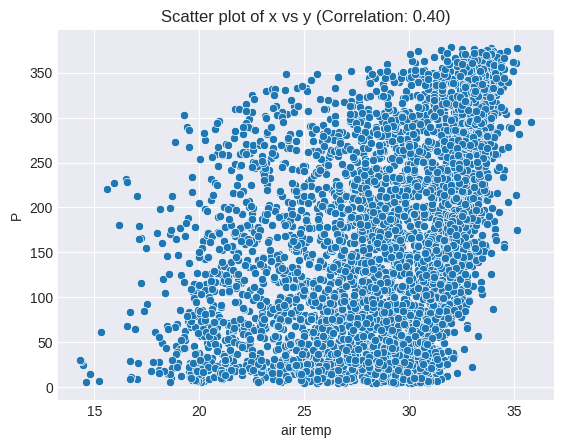

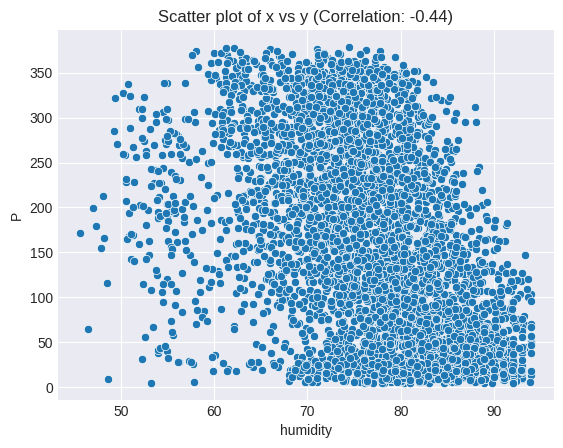

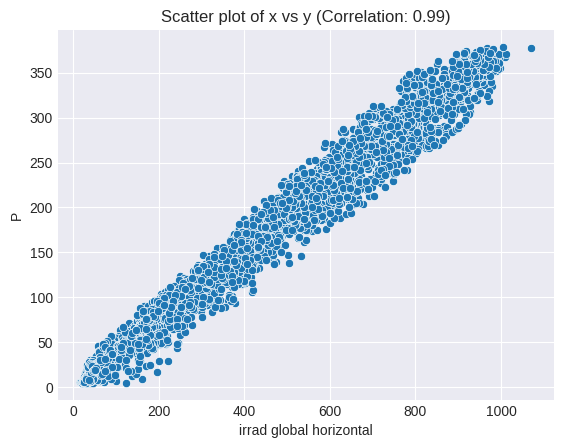

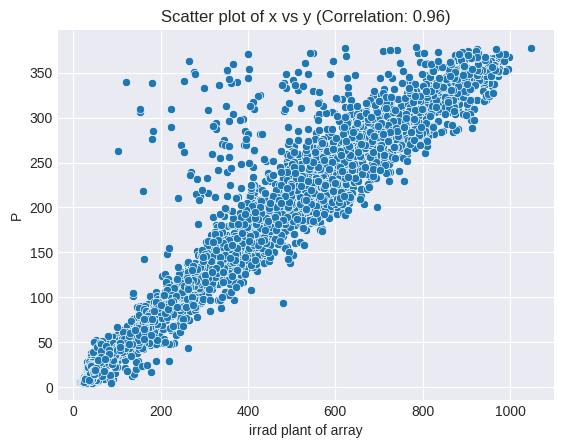

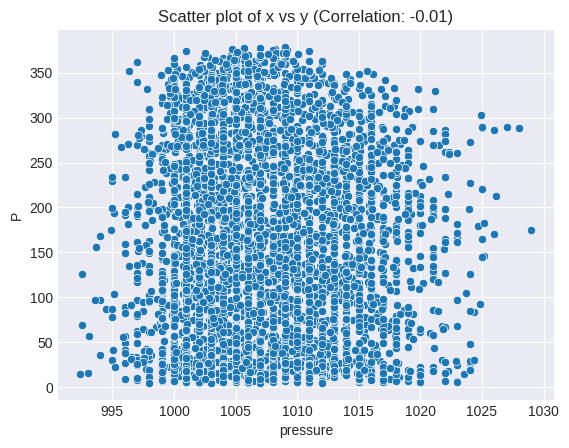

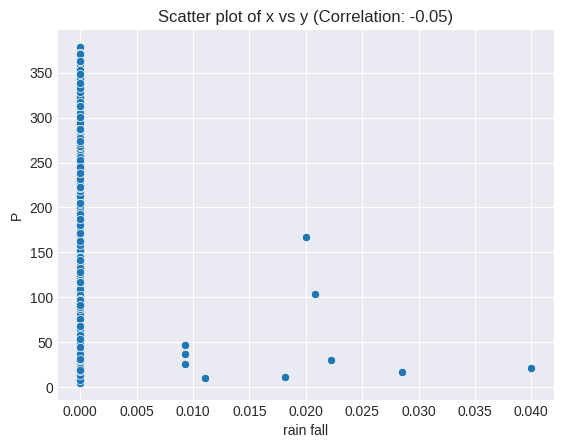

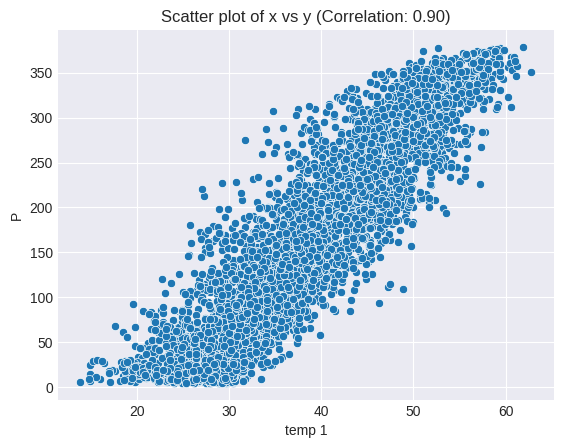

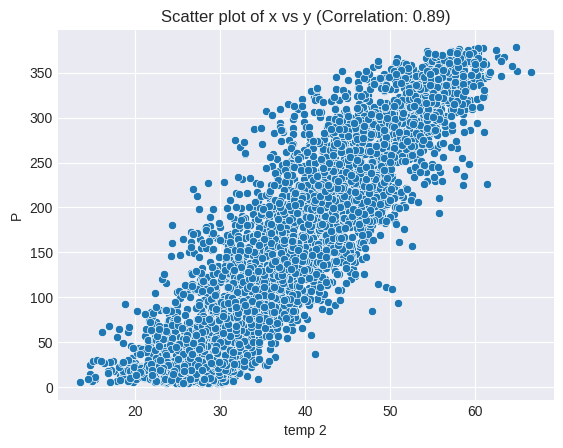

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide



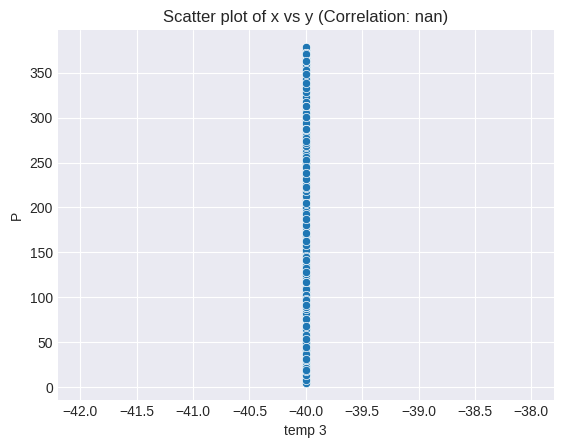

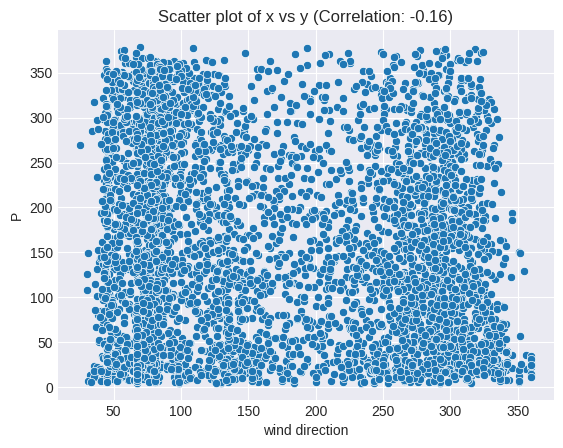

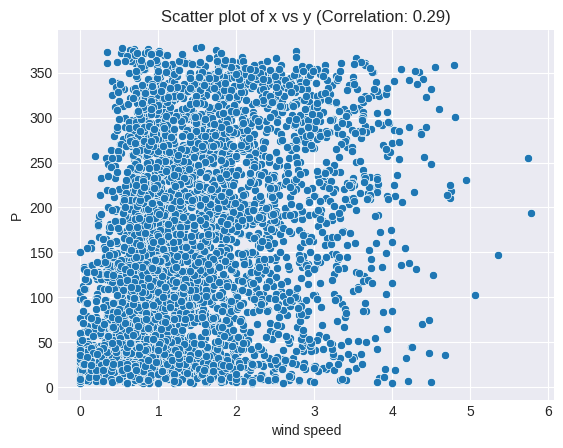

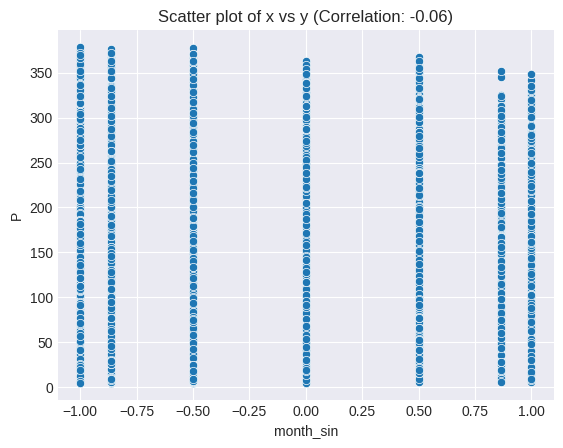

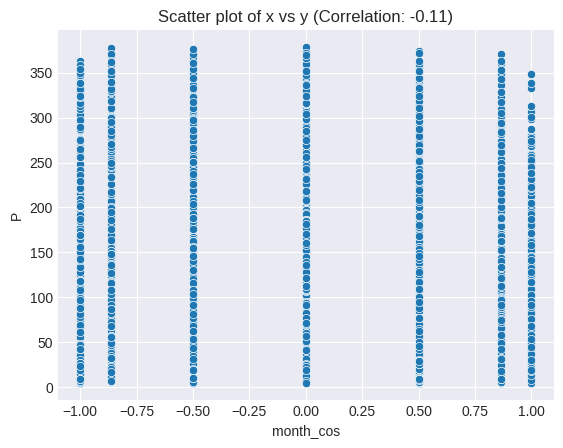

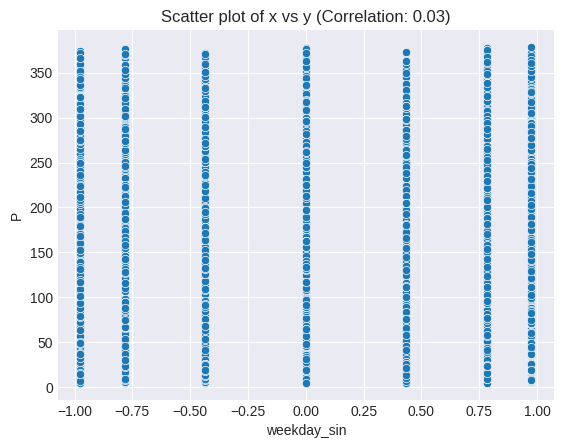

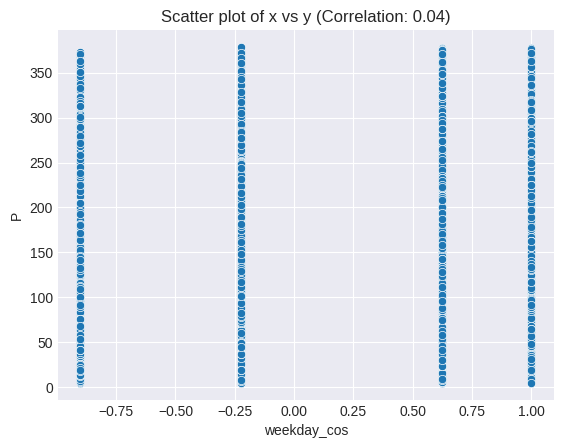

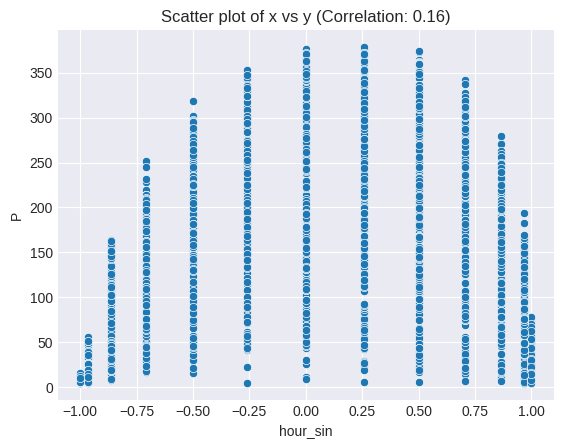

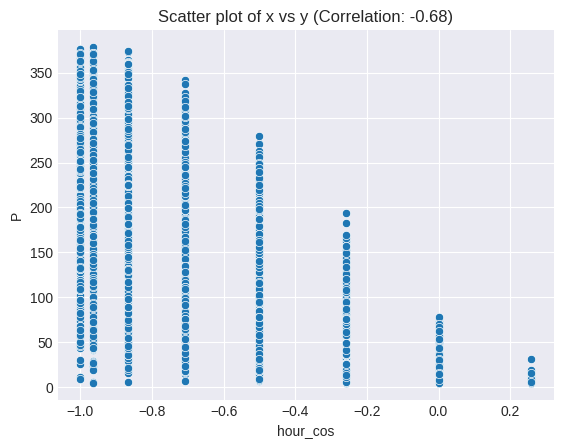

['air temp', 'humidity', 'irrad global horizontal', 'irrad plant of array', 'temp 1', 'temp 2', 'wind speed', 'hour_cos']
time: 6.2 s (started: 2025-05-19 10:45:44 +00:00)


In [10]:
target = 'P'
fe =[]
print("*************************************************************************")
print("**********************************"+target+"********************************")
print("*************************************************************************")
for i in exog_features:
    correlation = data[target].corr(data[i])
    # Vẽ biểu đồ
    sns.scatterplot(data=data, y=target, x=i)
    # Đặt tiêu đề với hệ số tương quan
    plt.title(f'Scatter plot of x vs y (Correlation: {correlation:.2f})')
    if abs(correlation)> 0.25: fe.append(i)
    plt.show()
print(fe)

# All

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[exog_features]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)

# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 7.86 ms (started: 2025-05-19 10:45:50 +00:00)


In [12]:
start_time = time.time()
search_spaces  = {
        'n_estimators': Integer(50, 250), # Use suggest_categorical for discrete values
        'learning_rate': Real(0.01, 1.0) # Use suggest_float for continuous range
    }

initial_model = GradientBoostingRegressor(random_state=123, loss='squared_error')
initial_model.fit(X_train, y_train)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
# Regressor hyperparameters search space
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv=cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

Best parameters found:  OrderedDict([('learning_rate', 0.18375651980345856), ('n_estimators', 250)])
Best cross-validation score:  -9.509958883328979
1922.2100355625153
time: 32min 2s (started: 2025-05-19 10:45:55 +00:00)


In [13]:
best_model = GradientBoostingRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)
test_score = mean_absolute_error(y_test, y_test_pred2)
print("Validation set mean absolute error:", test_score)
print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.011184930801391602
Validation set mean absolute error: 9.433741868379437
Validation set mean absolute error: 9.405755198025675
161.53614263376298
161.60793804002867
161.59066767227654
time: 4.09 s (started: 2025-05-19 11:20:02 +00:00)


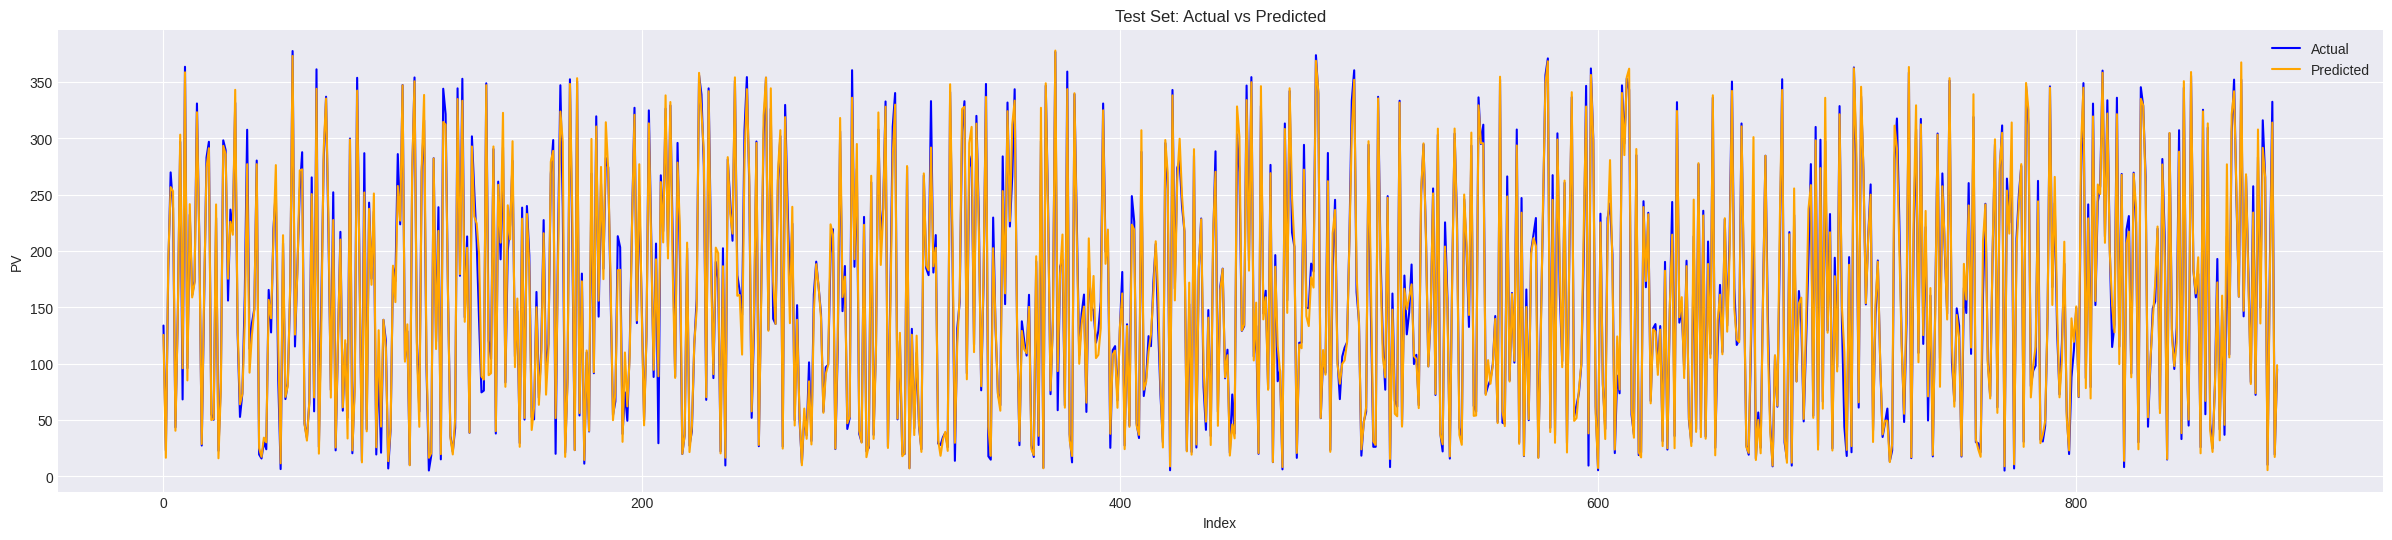

time: 602 ms (started: 2025-05-19 11:20:09 +00:00)


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 180.99394948196743
RMSE: 13.453399179462693
MAE: 9.405755198025675
MAPE: 9.917330709526174%
Relative MAE: 5.822693946178061%
Relative RMSE: 8.328414285566065%
time: 5.95 ms (started: 2025-05-19 11:20:13 +00:00)


In [16]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/GradientBoostingTree_PV_all_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Mounted at /content/drive
time: 17.3 s (started: 2025-05-19 11:20:24 +00:00)


In [17]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time

# Lưu về máy
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/PV_GradientBoostingTree_all.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.53 s (started: 2025-05-19 11:20:41 +00:00)


# Selected

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[fe]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)

# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 8.01 ms (started: 2025-05-19 11:20:43 +00:00)


In [19]:
start_time = time.time()
search_spaces  = {
        'n_estimators': Integer(50, 250), # Use suggest_categorical for discrete values
        'learning_rate': Real(0.01, 1.0) # Use suggest_float for continuous range
    }

initial_model = GradientBoostingRegressor(random_state=123, loss='squared_error')
initial_model.fit(X_train, y_train)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
# Regressor hyperparameters search space
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv=cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

Best parameters found:  OrderedDict([('learning_rate', 0.11466075065402237), ('n_estimators', 240)])
Best cross-validation score:  -10.320475778898508
1371.5113797187805
time: 22min 51s (started: 2025-05-19 11:20:43 +00:00)


In [20]:
best_model = GradientBoostingRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)
test_score = mean_absolute_error(y_test, y_test_pred2)
print("Validation set mean absolute error:", test_score)
print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.010540008544921875
Validation set mean absolute error: 10.378037227482809
Validation set mean absolute error: 10.373935999331712
161.53614263376298
161.45698114232295
161.48393288144013
time: 3.4 s (started: 2025-05-19 11:43:34 +00:00)


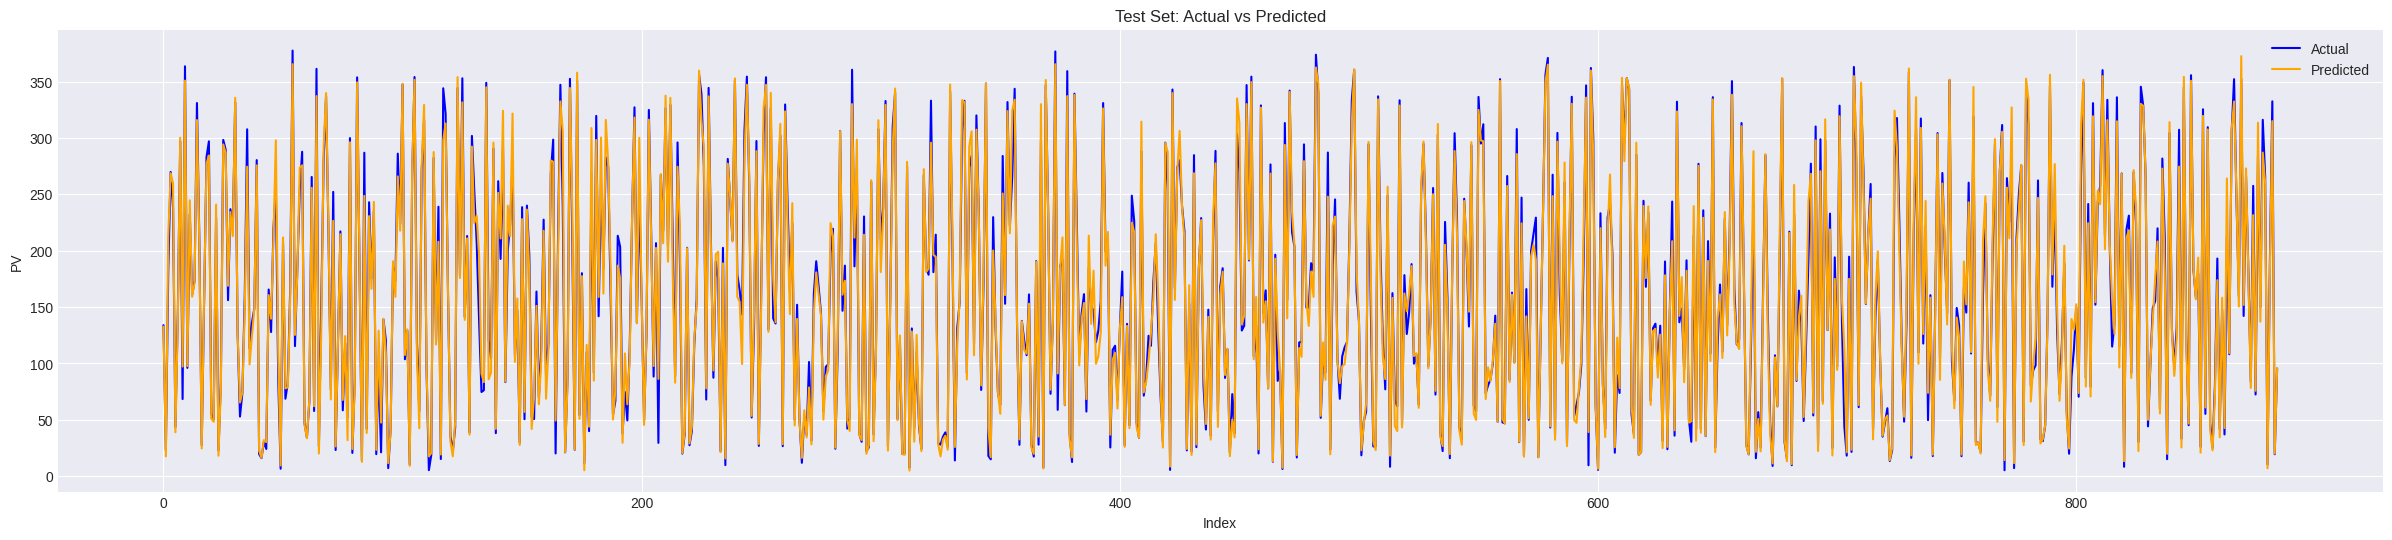

time: 405 ms (started: 2025-05-19 11:43:38 +00:00)


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 220.3102596286783
RMSE: 14.842852139285034
MAE: 10.373935999331712
MAPE: 10.46930437229339%
Relative MAE: 6.422052569901737%
Relative RMSE: 9.188564179681421%
time: 9.95 ms (started: 2025-05-19 11:43:38 +00:00)


In [23]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/GradientBoostingTree_PV_selected_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.54 s (started: 2025-05-19 11:43:38 +00:00)


In [24]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time

# Lưu về máy
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/PV_GradientBoostingTree_selected.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.4 s (started: 2025-05-19 11:43:40 +00:00)
